# Example of QAA model training

To train QAA model using our method you need pretrained face recognition model, dataset on which it was trained(or subset) and weights of classification layer.  
In this example we will use R100 trained on Glint360k dataset from insightface repo.  

# Step 0. Install dependencies

In [1]:
import sys
import os
sys.path.append("..")
from os.path import join
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import catboost as cb
import numpy as np
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

from eval_ijbc import validate_ijbc
from utils_ijbc import *
from recognition.models.iresnet import iresnet100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

device = "cuda"

# Step 1. Download first 15000 classes from Glint360K

<b> 1.1) Download archive with images and extract it as glint15k </b>

In [2]:
%%sh

if [ ! -d ./glint15k ]; then
    echo "Glint15k not founded! Downloading..."
    wget -nc -q http://download.cvartel.com/facesdk/archives/artifacts/ml/data/glint_15k.tar.gz 
    tar -xzf glint_15k.tar.gz --skip-old-files
    mv -vn glint glint15k
    rm ./glint_15k.tar.gz
fi

Glint15k not founded! Downloading...
renamed 'glint' -> 'glint15k'


In [3]:
dataset = ImageFolder("./glint15k", transform = transform)

Glint360K image examples


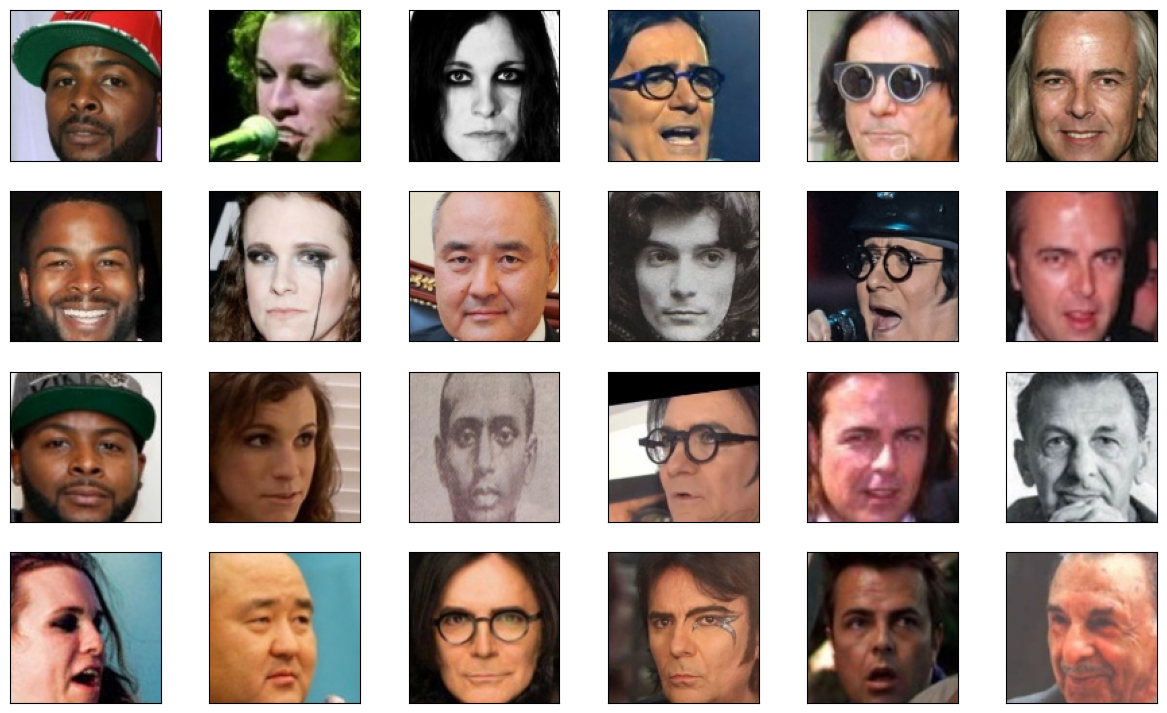

In [4]:
#remove transform to visualise
dataset.transform = None

n_rows = 4
n_cols = 6
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,9))
for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].imshow(dataset[10 * i* n_rows + 15 * j * n_cols][0])
        ax[i][j].tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
        
print("Glint360K image examples")
dataset.transform = transform

# Step 2. Set up face recognition model

We will use R100 trained on Glint360K.

<b>2.1) Download weights </b>

Download weights(backbone.pth) and put it as openhat_ai/recognition/weights/r100_glint360k.pth   
https://onedrive.live.com/?authkey=%21AFZjr283nwZHqbA&cid=4A83B6B633B029CC&id=4A83B6B633B029CC%215698&parId=4A83B6B633B029CC%215582&o=OneUp

<b>2.2) Add hooks that extract features from each batch normalization layer</b>

Input to BN has shape B×C×W×H. We reduce W and H dimensions, computing BxC variances.  
Then we reduce C, to compute mean and variance.  
We extract B×2 features from each BN, B×2*BN from network in total, where BN is count of batch normalization layers in network. </font>

In [5]:
from bn_extraction.models import VarMVExtractor
model_name = "r100_glint360k"
backbone_weights_path = f'../recognition/weights/{model_name}.pth'
backbone = iresnet100().to(device)
backbone.load_state_dict(torch.load(backbone_weights_path, map_location=device))
backbone_bnf = VarMVExtractor(backbone, device=device)

# Step 3. Prepare class centroids

Images that lie far crom related class centroid inside feature space cannot be well recognized by network.  
On that assumption we use similarity between image with centroid of related class as ground truth label.

<b> 3.1) Download class centroids (weights from softmax layer) </b>  
Download <i><u> rank_0_softmax_weight.pt </i></u>   and put it to <i><u> ./weights/</i></u>     
https://onedrive.live.com/?authkey=%21AFZjr283nwZHqbA&id=4A83B6B633B029CC%215582&cid=4A83B6B633B029CC   

In [6]:
centroids_path = "./weights/rank_0_softmax_weight.pt"
centroids = torch.load(centroids_path, map_location=device)
print(f"Loaded centroids for first {centroids.shape[0]} classes")

Loaded centroids for first 45029 classes


# Step 4. Prepare data & train QAA

We calculate features and train CatBoostRegressor.

In [7]:
from train_qaa import train_qaa
regressor_model_path = f"./weights/{model_name}_qaa.cbm"
batch_size = 1024

In [8]:
if not os.path.exists(regressor_model_path):
    print("Regressor not found.")
    train_qaa(backbone_bnf, dataset, centroids, batch_size=batch_size, device=device, save_path=regressor_model_path)
print("Found pretrained regressor. Loading...")
regressor = cb.CatBoostRegressor().load_model(regressor_model_path)
print("Successfully loaded pretrained regressor")

Found pretrained regressor. Loading...
Successfully loaded pretrained regressor


# Step 5 - Evaluation on IJB-C

We use evalutaion pipeline from insightface repository with some edits to add QAA filtering.  
To evaluate model we use IJB-C dataset with following methods:
- <b> TPR@FPR </b>  
  Compute TPR@FPR on full dataset and without ~5% of worst images (metrics should grow up).
- <b> Efficiency η </b>  
  We fix threshold on which FNMR=0.01, after filtering recompute FNMR with same threshold. We calculate difference of old and new FNMRs and divide it by fraction of discarded images.
 $$ \eta(r) = \frac{1}{r}\left(\frac{FNMR(0) - FNMR(r)}{FNMR(0)}   \right) $$

<b> 5.1) Download IJB Dataset and put it to /ijb/ </b>

Google drive: https://drive.google.com/file/d/1aC4zf2Bn0xCVH_ZtEuQipR2JvRb1bf8o/view?pli=1

In [17]:
%%sh

if [ ! -d ./ijb ]; then
    echo "IJBC not founded! Downloading..."
    pip install gdown
    gdown --fuzzy https://drive.google.com/file/d/1aC4zf2Bn0xCVH_ZtEuQipR2JvRb1bf8o/view?pli=1 -O ijb.tar
    tar -xf ijb.tar --skip-old-files
fi

<b> 5.2) Precalculate embeddings </b>

In [18]:
dataset_path = "./ijb/IJBC"
image_dir = dataset_path + "/loose_crop/"
original_tid_mid = dataset_path + "/meta/ijbc_face_tid_mid.txt"
original_5pts = dataset_path + "/meta/ijbc_name_5pts_score.txt"
original_pairs = dataset_path + "/meta/ijbc_template_pair_label.txt"

precalculated_path = "./precalculated/"
qualities_path = join(precalculated_path, "qualities.npy")
features_path = join(precalculated_path, "features.npy")

filtered_path = "./filtered_meta/"
    
use_norm_score = True
use_detector_score = True
use_flip_test = True

In [19]:
qualities = None
faceness_scores = None
img_feats = None

if not os.path.exists(precalculated_path):
    os.mkdir(precalculated_path)

if not os.path.exists(qualities_path) or not os.path.exists(features_path):
    print(f"Path {qualities_path} or {features_path} is invalid. Precalculating features...")
    qualities, faceness_scores, img_feats = precalculate_ijbc_features(backbone_bnf, regressor, image_dir, original_5pts,
                                                                       use_flip_test, batch_size=batch_size, device=device, save_path=precalculated_path)
    print("Successfully precalculated features.")
else:
    print("Features found.")
    img_feats = np.load(features_path)
    if img_feats.shape[1] == 512 and use_flip_test:
        print("No precalculated feature for flip test. Recalculating...")
        qualities, faceness_scores, img_feats = precalculate_ijbc_features(backbone_bnf, regressor, image_dir, original_5pts,
                                                                           use_flip_test, batch_size=batch_size, device=device, save_path=precalculated_path)
        print("Successfully recalculated features.")
    else:        
        qualities = np.load(qualities_path)
        faceness_scores = pd.read_csv(original_5pts, header=None,delim_whitespace=True)[11].values
print("Features loaded.")

Path ./precalculated/qualities.npy or ./precalculated/features.npy is invalid. Precalculating features...


100%|██████████████████████████████████| 469375/469375 [31:32<00:00, 248.07it/s]


Precalculated qualities and features are saved to ./precalculated/
Successfully precalculated features.
Features loaded.


<b> 5.3) Validate model on full IJB-C Dataset </b>

Time: 0.06 s. 
Feature Shape: (469375 , 1024) .
Calculating template features...
Time: 6.48 s. 
Finished 0/157 pair batches.
Finished 51/157 pair batches.
Finished 102/157 pair batches.
Finished 153/157 pair batches.
Finished all pair batches
Time: 34.36 s. 
+-----------+-------+-------+--------+-------+-------+-------+
|  Methods  | 1e-06 | 1e-05 | 0.0001 | 0.001 |  0.01 |  0.1  |
+-----------+-------+-------+--------+-------+-------+-------+
| ijbc-IJBC | 90.58 | 95.88 | 97.32  | 98.19 | 98.73 | 99.24 |
+-----------+-------+-------+--------+-------+-------+-------+


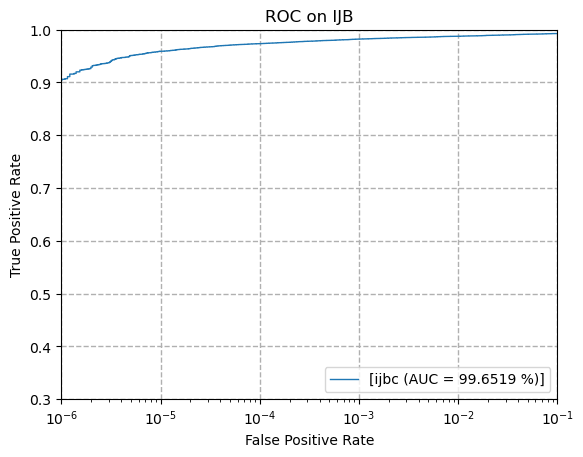

In [20]:
tpr_fpr_orig, thresholds = validate_ijbc(backbone, dataset_path, original_tid_mid, original_pairs, original_5pts, device=device,
            precalculated_img_feats=img_feats, precalculated_faceness_scores=faceness_scores,
            use_norm_score = use_norm_score, use_detector_score = use_detector_score, use_flip_test = use_flip_test)

<b> 5.4) Validate model on IJB-C Dataset filtered with QAA </b>

In [21]:
if not os.path.exists(filtered_path):
    os.mkdir(filtered_path)

filter_percent = 5
filtered_img_feats, filtered_faceness_scores, accurate_filter_percent, lowest_quality_i = filter_ijbc_by_qaa(original_tid_mid,
original_5pts, original_pairs, qualities, img_feats, faceness_scores, filter_percent=filter_percent)

Rejected  4.575 % of images
Images left: 447900/469375

Generated new tid_mid annotation
Saved in ./filtered_meta/ijbc_face_tid_mid_qaa_filtered.txt
Generated new landmark annotation
Saved in ./filtered_meta/ijbc_name_5pts_score_qaa_filtered.txt

Found 69 empty templates
Removing pairs with empty template...

Removed 86375 pairs
Generated new pair annotation
Saved in ./filtered_meta/ijbc_template_pair_label_qaa_filtered.txt

Pairs left: 15572114/15658489


In [22]:
filtered_annot = join(filtered_path, "ijbc_face_tid_mid_qaa_filtered.txt")
filtered_5pts = join(filtered_path, "ijbc_name_5pts_score_qaa_filtered.txt")
filtered_pairs = join(filtered_path, "ijbc_template_pair_label_qaa_filtered.txt")

Images with low quality from IJB-C


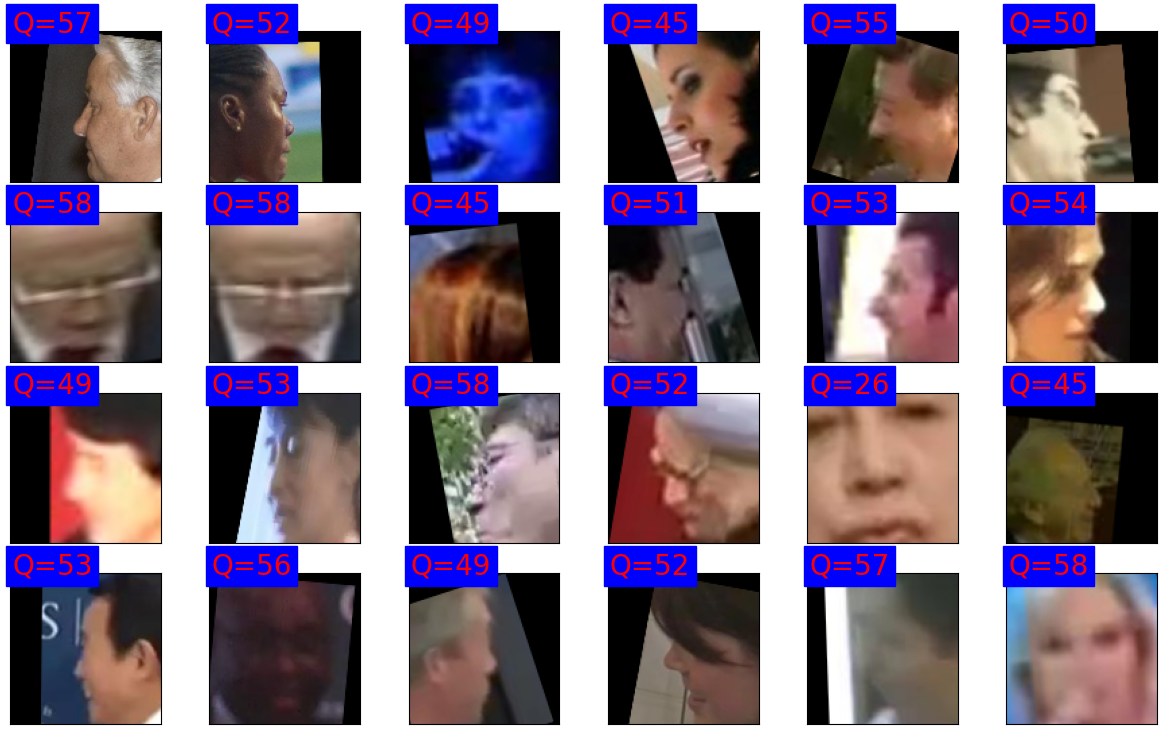

In [23]:
#Images with low quality from IJB-C
n_rows = 4
n_cols = 6
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15,9))

landmark_df = pd.read_csv(original_5pts, sep=' ', header=None).values

print("Images with low quality from IJB-C")
for i in range(n_rows):
    for j in range(n_cols):
        id = lowest_quality_i[100 * i * n_rows + 10 * j * n_cols]
        quality = qualities[id]
        row = landmark_df[id]
        img = cv2.imread(join(image_dir, row[0]))
        landmark5 = row[1:11].reshape((5,2)).astype(np.float64)
        img = normalize(img, landmark5)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i][j].tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
        t = ax[i][j].text(1, 0, f'Q={quality}', c="r", fontsize=20)
        t.set_bbox(dict(facecolor='blue', alpha=1, edgecolor='blue'))
        ax[i][j].imshow(img)

Time: 0.04 s. 
Feature Shape: (447900 , 1024) .
Calculating template features...
Time: 4.59 s. 
Finished 0/156 pair batches.
Finished 51/156 pair batches.
Finished 102/156 pair batches.
Finished 153/156 pair batches.
Finished all pair batches
Time: 34.14 s. 
+-----------+-------+-------+--------+-------+-------+-------+
|  Methods  | 1e-06 | 1e-05 | 0.0001 | 0.001 |  0.01 |  0.1  |
+-----------+-------+-------+--------+-------+-------+-------+
| ijbc-IJBC | 92.22 | 96.49 | 97.74  | 98.44 | 98.91 | 99.32 |
+-----------+-------+-------+--------+-------+-------+-------+


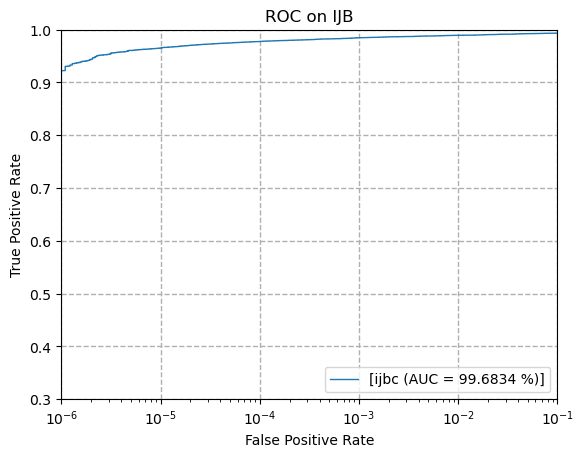

In [24]:
tpr_fpr_filtered, _, efficiency = validate_ijbc(backbone, dataset_path, filtered_annot, filtered_pairs, filtered_5pts, device=device,
             precalculated_img_feats=filtered_img_feats, precalculated_faceness_scores=filtered_faceness_scores,
            use_norm_score = use_norm_score, use_detector_score = use_detector_score, use_flip_test = use_flip_test,
            calculate_efficiency=True, efficiency_threshold=thresholds, filter_percent=accurate_filter_percent)

In [25]:
print("Original dataset metrics:")
print(tpr_fpr_orig)
print("QAA filtered metrics:")
print(tpr_fpr_filtered)
print(f"Efficiency (discarded {round(accurate_filter_percent, 3)}% images) : {efficiency}")

Original dataset metrics:
+-----------+-------+-------+--------+-------+-------+-------+
|  Methods  | 1e-06 | 1e-05 | 0.0001 | 0.001 |  0.01 |  0.1  |
+-----------+-------+-------+--------+-------+-------+-------+
| ijbc-IJBC | 90.58 | 95.88 | 97.32  | 98.19 | 98.73 | 99.24 |
+-----------+-------+-------+--------+-------+-------+-------+
QAA filtered metrics:
+-----------+-------+-------+--------+-------+-------+-------+
|  Methods  | 1e-06 | 1e-05 | 0.0001 | 0.001 |  0.01 |  0.1  |
+-----------+-------+-------+--------+-------+-------+-------+
| ijbc-IJBC | 92.22 | 96.49 | 97.74  | 98.44 | 98.91 | 99.32 |
+-----------+-------+-------+--------+-------+-------+-------+
Efficiency (discarded 4.575% images) : 2.6447481913994695


## Conclusion

    As you can see, trained QAA improve metrics of original model.  
    You can try other components to make your own QAA:
        1. Change dataset in step 1. and centroids in step 3.
        2. Change model in step 2.
        3. Write custom feature extractor
    Models trained here can be further used with other datasets